In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import yaml
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from src.data.prepare_data import prepare_data
from src.models.utils import imbalanced_sampling, set_global_seed

In [2]:
# read config
with open("../config.yml", "r") as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

# ensure reproducibility
set_global_seed(seed=config["general"]["seed"])

# parameters
N_TRIALS = 3
EPOCHS = 5
BATCH_SIZE = 32

In [3]:
# load and prepare data
df = pd.read_csv("../" + config["data_loader"]["path"])
df = prepare_data(df=df)
display(df.head())

# check class distributions
df["label"].value_counts(normalize=True)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,-1.996580,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996580,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,-1.996558,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,-1.996558,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996537,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


label
0    0.998273
1    0.001727
Name: proportion, dtype: float64

**Train and Test Set**
- Split whole set into train and test sets using strat sampling
- Apply oversampling as the number of positive instances is small

In [4]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df["label"]
    , test_size=config["train_test_split"]["test_size"]
    , random_state=config["general"]["seed"]
    , shuffle=True
    , stratify=df["label"]
    )

# split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train
    , test_size=config["train_test_split"]["test_size"]
    , random_state=config["general"]["seed"]
    , shuffle=True
    , stratify=y_train
    )

In [5]:
# apply oversampling to the train set
X_train_rs, y_train_rs = imbalanced_sampling(
    method="over"
    , X_train=X_train
    , y_train=y_train
)

# check class distributions
print(
    y_train.value_counts(normalize=True)
    , y_train_rs.value_counts(normalize=True)
    )

label
0    0.998273
1    0.001727
Name: proportion, dtype: float64 label
0    0.5
1    0.5
Name: proportion, dtype: float64


**Optimization**
- Perform hyper-param tuning through bayesian search
- Train and Evaluate model

In [6]:
def model_builder(hp):

    inputs = keras.Input(shape=(30,), name="features")
    wide = inputs
    x = inputs

    # deep path hyperparams
    n_layers = hp.Int("n_layers", min_value=2, max_value=8, step=1)
    for i in range(n_layers):
      n_units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
      activation_f = hp.Choice(f"activation_{i}", values=["sigmoid", "relu"])
      dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)

      x = keras.layers.Dense(n_units, activation=activation_f)(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Dropout(dropout_rate)(x)

    merged = keras.layers.concatenate([wide, x])
    output = keras.layers.Dense(1, activation="sigmoid")(merged)

    model = keras.Model(inputs, output)

    # tune learning rate too
    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    model.compile(
       optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
       loss="binary_crossentropy",
       metrics=["accuracy"]
       )
    return model

In [7]:
bayesian_search_tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=N_TRIALS,
    executions_per_trial=1,
    seed=config["general"]["seed"],
    overwrite=False
    #, directory=
    , project_name="keras_tuner"

)

bayesian_search_tuner.search(
    X_train_rs.to_numpy(), y_train_rs.to_numpy(),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
    #, class_weight={0: 1.0, 1: 2.0}
)

Trial 3 Complete [00h 09m 32s]
val_accuracy: 0.9901692867279053

Best val_accuracy So Far: 0.9922388792037964
Total elapsed time: 00h 32m 18s


In [8]:
bayesian_search_tuner.results_summary()

Results summary
Results in .\keras_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
n_layers: 5
units_0: 64
activation_0: relu
dropout_rate_0: 0.4
units_1: 256
activation_1: sigmoid
dropout_rate_1: 0.5
learning_rate: 0.01
units_2: 160
activation_2: sigmoid
dropout_rate_2: 0.2
units_3: 128
activation_3: relu
dropout_rate_3: 0.30000000000000004
units_4: 128
activation_4: sigmoid
dropout_rate_4: 0.1
units_5: 32
activation_5: relu
dropout_rate_5: 0.4
Score: 0.9922388792037964

Trial 2 summary
Hyperparameters:
n_layers: 8
units_0: 96
activation_0: sigmoid
dropout_rate_0: 0.2
units_1: 224
activation_1: sigmoid
dropout_rate_1: 0.2
learning_rate: 0.0001
units_2: 224
activation_2: sigmoid
dropout_rate_2: 0.2
units_3: 160
activation_3: sigmoid
dropout_rate_3: 0.30000000000000004
units_4: 192
activation_4: sigmoid
dropout_rate_4: 0.4
units_5: 64
activation_5: sigmoid
dropout_rate_5: 0.1
units_6: 32
activation_6: sigmoid
dropout_rate_6:

In [9]:
# get best hyperparameters and build best model with tuned hyperparams
best_hps = bayesian_search_tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = bayesian_search_tuner.hypermodel.build(best_hps)

# fit on the full training set
X_train, y_train = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])
X_train_rs, y_train_rs = imbalanced_sampling(
    method="over"
    , X_train=X_train
    , y_train=y_train
)

history = best_model.fit(
    X_train_rs.to_numpy(), y_train_rs.to_numpy(),
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_data=(X_test.to_numpy(), y_test.to_numpy())
)

# Evaluate on the test set
best_model.evaluate(X_test.to_numpy(), y_test.to_numpy())

Epoch 1/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9578 - loss: 0.1084 - val_accuracy: 0.9897 - val_loss: 0.0483
Epoch 2/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.9620 - loss: 0.0944 - val_accuracy: 0.9898 - val_loss: 0.0536
Epoch 3/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9594 - loss: 0.1013 - val_accuracy: 0.9829 - val_loss: 0.0687
Epoch 4/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - accuracy: 0.9573 - loss: 0.1071 - val_accuracy: 0.9793 - val_loss: 0.0927
Epoch 5/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 89s 5ms/step - accuracy: 0.9542 - loss: 0.1163 - val_accuracy: 0.9804 - val_loss: 0.0953
Epoch 6/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 106s 6ms/step - accuracy: 0.9534 - loss: 0.1189 - val_accuracy: 0.9761 - val_loss: 0.0936
Epoch 7/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 90s 5ms/step - accuracy: 0.9517 - loss: 0.1218 - val_accuracy: 0.9822 - val_loss: 0.0869
Epoch 8/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 91s 5ms/step - accuracy:

[0.12694388628005981, 0.9754230976104736]

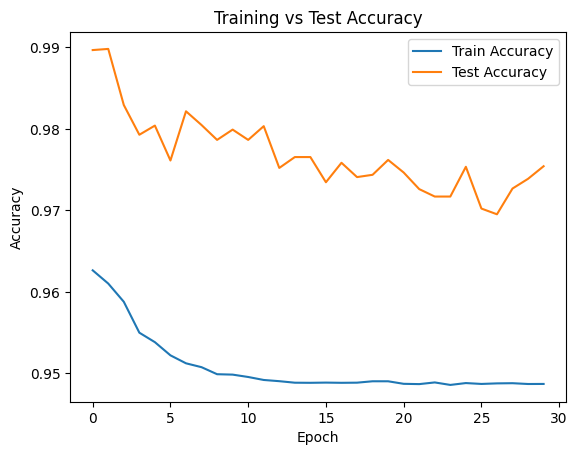

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Test Accuracy")
plt.show()